In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Black-Scholes parameters
sigma = 0.2  # Volatility
r = 0.05     # Risk-free rate
K = 1.0      # Strike price
T = 1.0      # Time to maturity

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, S, t):
        inputs = torch.cat((S, t), dim=1)
        return self.hidden(inputs)

# Initialize model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training points
N_collocation = 100  # Number of PDE points
S_collocation = torch.linspace(0, 2, N_collocation, requires_grad=True).view(-1, 1)
t_collocation = torch.linspace(0, T, N_collocation, requires_grad=True).view(-1, 1)


# Boundary and terminal conditions for Black-Scholes Call Option

# Boundary conditions at S = 0 and S = 2
S_boundary = torch.tensor([[0.0], [2.0]], dtype=torch.float32, requires_grad=True)
t_boundary = torch.linspace(0, T, N_collocation).view(-1, 1)  # Time range for boundary conditions

# V(0, t) = 0 (Call option is worthless if stock price is 0)
V_boundary_low = torch.zeros_like(t_boundary)

# V(S_max, t) = S_max - K * exp(-r(T - t)) (Intrinsic value approximation for large S)
V_boundary_high = S_boundary[1] - K * torch.exp(-r * (T - t_boundary))

# Terminal condition at t = T
S_terminal = torch.linspace(0, 2, N_collocation, requires_grad=True).view(-1, 1)
t_terminal = T * torch.ones_like(S_terminal)

# Payoff function at expiration: max(S - K, 0)
V_terminal = torch.maximum(S_terminal - K, torch.tensor(0.0))

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Compute V_theta(S, t)
    V = model(S_collocation, t_collocation)

    # Compute first derivatives
    dV_dt = torch.autograd.grad(V, t_collocation, torch.ones_like(V), create_graph=True, retain_graph=True)[0]
    dV_dS = torch.autograd.grad(V, S_collocation, torch.ones_like(V), create_graph=True, retain_graph=True)[0]

    # Compute second derivative
    d2V_dS2 = torch.autograd.grad(dV_dS, S_collocation, torch.ones_like(dV_dS), create_graph=True, retain_graph=True)[0]

    # Black-Scholes PDE Residual Loss
    residual = dV_dt + 0.5 * sigma**2 * S_collocation**2 * d2V_dS2 + r * S_collocation * dV_dS - r * V
    pde_loss = torch.mean(residual**2)

    # Compute terminal loss
    V_t = model(S_terminal, t_terminal)
    terminal_loss = torch.mean((V_t - V_terminal)**2)

    # Compute boundary loss
    S_boundary_low = torch.zeros_like(t_boundary)  # S = 0 for all times
    S_boundary_high = 2.0 * torch.ones_like(t_boundary)  # S = 2 for all times

    V_b_low = model(S_boundary_low, t_boundary)
    V_b_high = model(S_boundary_high, t_boundary)

    boundary_loss = torch.mean((V_b_low - V_boundary_low)**2) + torch.mean((V_b_high - V_boundary_high)**2)

    # Total loss
    loss = pde_loss + terminal_loss + boundary_loss

    # Backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.544731
Epoch 500, Loss: 0.000419
Epoch 1000, Loss: 0.000214
Epoch 1500, Loss: 0.000179
Epoch 2000, Loss: 0.000138
Epoch 2500, Loss: 0.000119
Epoch 3000, Loss: 0.000089
Epoch 3500, Loss: 0.000080
Epoch 4000, Loss: 0.000577
Epoch 4500, Loss: 0.000059


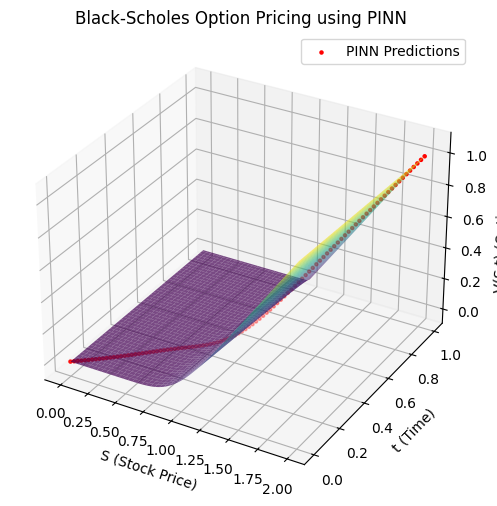

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# Generate test points
S_test = torch.linspace(0, 2, 100).view(-1, 1)  # Stock prices in range [0, 2]
t_test = torch.linspace(0, T, 100).view(-1, 1)  # Time in range [0, T]

V_pred = model(S_test, t_test).detach().numpy()

# Create mesh grid for visualization
S_mesh, T_mesh = np.meshgrid(torch.linspace(0, 2, 100), torch.linspace(0, T, 100))



def black_scholes_call(S, t, K, r, sigma, T):
    """
    Computes the exact Black-Scholes price for a European call option.
    Handles cases where S=0 and t=T to prevent divide-by-zero errors.
    """
    from scipy.stats import norm

    epsilon = 1e-8  # Small value to avoid division by zero
    S = np.maximum(S, epsilon)  # Avoid log(0)
    tau = np.maximum(T - t, epsilon)  # Ensure tau > 0 for sqrt(T-t)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)


# Compute exact solution for all (S, t) points in the grid
V_exact = np.zeros_like(S_mesh)
for i in range(S_mesh.shape[0]):
    for j in range(S_mesh.shape[1]):
        if T_mesh[i, j] < T:  # Ensure valid time inputs
            V_exact[i, j] = black_scholes_call(S_mesh[i, j], T_mesh[i, j], K, r, sigma, T)
        else:
            V_exact[i, j] = max(S_mesh[i, j] - K, 0)  # Terminal payoff

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the exact Black-Scholes solution as a surface
ax.plot_surface(S_mesh, T_mesh, V_exact, cmap="viridis", alpha=0.7, edgecolor='none')

# Plot PINN predictions as scatter points
ax.scatter(S_test.numpy(), t_test.numpy(), V_pred, color='r', s=5, label="PINN Predictions")

# Labels and title
ax.set_xlabel("S (Stock Price)")
ax.set_ylabel("t (Time)")
ax.set_zlabel("V(S,t) (Option Price)")
ax.set_title("Black-Scholes Option Pricing using PINN")

# Show the legend
plt.legend()
plt.show()


Evaluation Metrics:
Mean Squared Error (MSE): 6.129659e-05
Mean Absolute Error (MAE): 5.754290e-03
Relative Error: 0.018274
R² Score: 0.999447


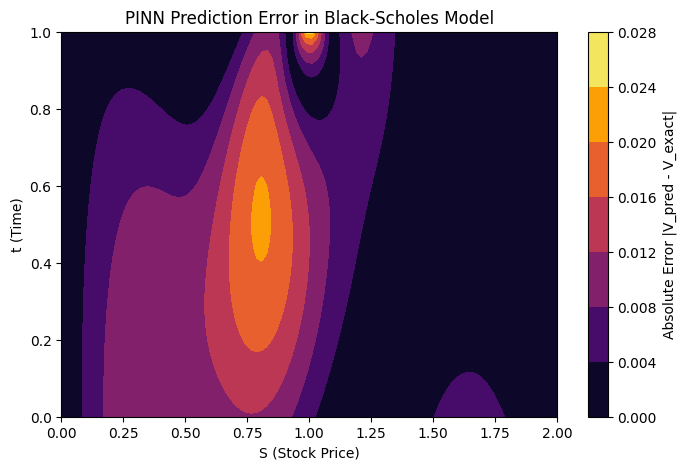

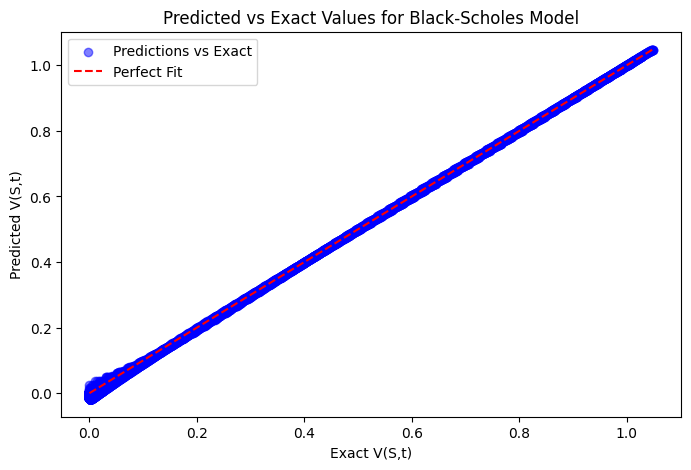

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Convert test grid to PyTorch tensors
S_test_tensor = torch.tensor(S_mesh.flatten(), dtype=torch.float32).view(-1, 1)
T_test_tensor = torch.tensor(T_mesh.flatten(), dtype=torch.float32).view(-1, 1)

# Compute PINN predictions on the mesh grid
V_pred = model(S_test_tensor, T_test_tensor).detach().numpy().reshape(100, 100)

# Compute evaluation metrics
mse = np.mean((V_pred - V_exact) ** 2)
mae = np.mean(np.abs(V_pred - V_exact))
relative_error = np.linalg.norm(V_pred - V_exact) / np.linalg.norm(V_exact)
r2 = r2_score(V_exact.flatten(), V_pred.flatten())

# Print results
print(f"Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6e}")
print(f"Mean Absolute Error (MAE): {mae:.6e}")
print(f"Relative Error: {relative_error:.6f}")
print(f"R² Score: {r2:.6f}")

# Plot Absolute Error Heatmap
plt.figure(figsize=(8, 5))
plt.contourf(S_mesh, T_mesh, np.abs(V_pred - V_exact), cmap="inferno")
plt.colorbar(label="Absolute Error |V_pred - V_exact|")
plt.xlabel("S (Stock Price)")
plt.ylabel("t (Time)")
plt.title("PINN Prediction Error in Black-Scholes Model")
plt.show()

# Plot Predictions vs True Values
plt.figure(figsize=(8, 5))
plt.scatter(V_exact.flatten(), V_pred.flatten(), alpha=0.5, color='blue', label="Predictions vs Exact")
plt.plot([V_exact.min(), V_exact.max()], [V_exact.min(), V_exact.max()], 'r--', label="Perfect Fit")
plt.xlabel("Exact V(S,t)")
plt.ylabel("Predicted V(S,t)")
plt.title("Predicted vs Exact Values for Black-Scholes Model")
plt.legend()
plt.show()
